## Part 1: Customer Segmentation Report

In [147]:
import numpy as np
import pandas as pd
import sys
import pickle
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.externals import joblib

from fit_clustering import build_model

%matplotlib inline

In [28]:
def print_cluster_props():
    # Compare the proportion of data in each cluster for the customer data to the
    # proportion of data in each cluster for the general population.

    pop = pd.Series(population_labels)
    cust = pd.Series(customer_labels)

    plt.subplot(2, 1, 1)
    ax1 = plt.bar(pop.value_counts().index, pop.value_counts() / pop.value_counts().sum())
    plt.ylabel('Population %')

    plt.subplot(2, 1, 2)
    ax2 = plt.bar(cust.value_counts().index, cust.value_counts() / cust.value_counts().sum())
    plt.ylabel('Customer %')

    plt.show()

In [56]:
def print_interesting_features(features, components, i):
    # Map weights for the principal component to corresponding feature names
    # and then print the linked values, sorted by weight.    
    feature_weights = dict(zip(features, components[i]))
    feature_weights_sorted = sorted(feature_weights.items(), key=lambda kv: kv[1])
    print('Lowest:')
    for feature, weight in feature_weights_sorted[:3]:
        print('\t{:20} {:.3f}'.format(feature, weight))
        
    print('Highest:')
    for feature, weight in feature_weights_sorted[-3:]:
        print('\t{:20} {:.3f}'.format(feature, weight))

In [6]:
# load the cleaned data
azdias_clean = pd.read_csv('data/Udacity_AZDIAS_052018_clean.csv', sep=';')

In [16]:
# Load cleaned customer data
customers_clean = pd.read_csv('data/Udacity_CUSTOMERS_052018_clean.csv', sep=';')

In [23]:
# build model
pca_n = 76
n_clusters = 5
clust_model = build_model(pca_n, n_clusters)

print('Fitting model...')
clust_model.fit(azdias_clean)

print('Saving model...')
f = open('clust_model' + str(n_clusters) + '.pkl', 'wb')
pickle.dump(clust_model, f)

Fitting model...
Saving model...


In [34]:
# or load model if already fitted
clust_model = joblib.load('clust_model5.pkl')

In [35]:
population_labels = clust_model.predict(azdias_clean)
population_labels[:10]

array([2, 2, 0, 3, 2, 2, 2, 0, 3, 4])

In [36]:
customer_labels = clust_model.predict(customers_clean)
customer_labels[:10]

array([0, 4, 0, 3, 0, 0, 0, 4, 3, 3])

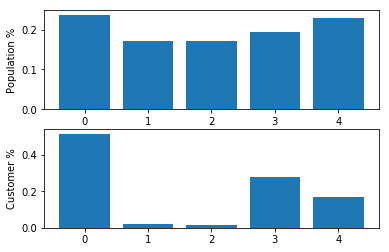

In [37]:
# Five clusters
print_cluster_props()

In [59]:
# PCA
for i in range(3):
    print('PCA'+str(i))
    print_interesting_features(azdias_clean.columns.values, clust_model.named_steps['pca'].components_, i)
    print()

PCA0
Lowest:
	HH_EINKOMMEN_SCORE   -0.151
	CAMEO_DEUG_2015      -0.144
	wealth               -0.142
Highest:
	D19_VERSAND_ANZ_24   0.159
	ONLINE_AFFINITAET    0.167
	D19_GESAMT_ANZ_24    0.173

PCA1
Lowest:
	ALTERSKATEGORIE_GROB -0.231
	FINANZ_VORSORGER     -0.215
	FINANZ_MINIMALIST    -0.185
Highest:
	SEMIO_REL            0.208
	decade               0.229
	FINANZ_SPARER        0.240

PCA2
Lowest:
	SEMIO_KULT           -0.171
	SEMIO_REL            -0.166
	PLZ8_ANTG1           -0.165
Highest:
	EWDICHTE             0.169
	PLZ8_ANTG3           0.170
	ORTSGR_KLS9          0.172



- PCA0 is an indicator of purchasing activity and wealth
- PCA1 is a indicator of lack of religiousness, youth, free spending
- PCA2 is an indicator of population density and urbaness

In [38]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

print(cust.value_counts() / cust.value_counts().sum())

0    0.514465
3    0.279154
4    0.169026
1    0.022406
2    0.014949
dtype: float64


### Cluster 0: very over-represented

In [54]:
clust_model.named_steps['kmeans'].cluster_centers_[0][:3]

array([ 1.449292  , -3.49042956, -0.75401977])

Cluster 0 has a very low value for pca1. This indicates this cluster is religious and savers

In [60]:
# Cluster 1: under-represented
clust_model.named_steps['kmeans'].cluster_centers_[1][:3]

array([-3.00776022,  4.10574762,  0.6017835 ])

In [62]:
# Cluster 2: under-represented
clust_model.named_steps['kmeans'].cluster_centers_[2][:3]

array([-0.86305695,  1.09365766, -3.31833991])

In [81]:
clust_model.named_steps['kmeans'].cluster_centers_.shape

(5, 76)

In [125]:
clusters_df=pd.DataFrame(clust_model.named_steps['kmeans'].cluster_centers_[:,:3])
clusters_df.index.name = 'cluster'
clusters_df.sort_index(ascending=False)

,0,1,2
cluster,,,
4,-3.473253,-1.652005,1.981922
3,5.751756,1.626052,0.977445
2,-0.863057,1.093658,-3.318340
1,-3.007760,4.105748,0.601783
0,1.449292,-3.490430,-0.754020


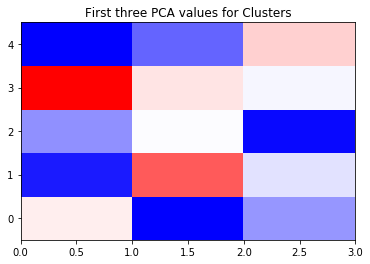

In [149]:
color_map = matplotlib.cm.get_cmap('bwr')

plt.pcolor(clusters_df, cmap=color_map);
plt.title("First three PCA values for Clusters")
plt.yticks(np.arange(0.5, len(clusters_df.index)), clusters_df.index)

plt.show()